In [44]:
"""

f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. R (R studio is the easiest option: https://www.rstudio.com/products/rstudio/download/).
Installing R packages is easy, in R studio, command install.packages("package_name") works
(https://www.dummies.com/programming/r/how-to-install-load-and-unload-packages-in-r/)
The following R packages are required:
    1a. RcppCNPy
    1b. DiceKriging
    1c. GPareto

2. rpy2 -- which runs R under the hood (pip install rpy2 should work)
# http://rpy.sourceforge.net/rpy2/doc-2.1/html/index.html
# conda install -c r rpy2

Built by N. Ramachandra and M. Binois 
"""

##### Generic packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os


###### R kernel imports from rpy2 #####
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()
from rpy2.robjects import r
from rpy2.robjects.packages import importr


####### PLOTTING SETTINGS #####
from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec


plt.rc('text', usetex=True)  # Slower
plt.rc('axes',labelsize= 10)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


########## R imports ############
# RcppCNPy = importr('RcppCNPy')
# RcppCNPy.chooseCRANmirror(ind=1) # select the first mirror in the list
## There are other importr calls in PCA and GP functions


In [45]:
############################# PARAMETERS ##############################
nRankMax = 2 ## Number of basis vectors in truncated PCA
del_idx =  [5, 25, 4, 42]  ## holdouts for testing
snap_ID = 97
############################# INPUT FILES ##############################

plotsDir = "./Plots/" ## Data folder
# dataDir = "./Data/Emulator_data/" ## Data folder
dataDir = "./Data/Emulator213bins/" ## Data folder

paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(snap_ID) + '.txt'
GPmodel = '"GP_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID) +'.RData"'  ## Double and single quotes are necessary
## DELETE the GPmodels or provide a new name if you want a new calculation
# num_holdout = 4
print(GPmodel)
################################# I/O #################################


loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
parameter_array_all = np.loadtxt(paramIn)
z_ID = az[snap_ID, 1]

########################## Deleting hold-out from training ##############


PmPl = np.delete(PmPl_all, del_idx, axis = 0)
parameter_array = np.delete(parameter_array_all, del_idx, axis = 0)


####################### porting to R backend #######################

nr, nc = PmPl[:,:].shape
y_train = ro.r.matrix(PmPl[:,:], nrow=nr, ncol=nc)
ro.r.assign("y_train2", y_train)
r('dim(y_train2)')

nr, nc = parameter_array[:,:].shape
u_train = ro.r.matrix(parameter_array[:,:], nrow=nr, ncol=nc)
ro.r.assign("u_train2", u_train)
r('dim(u_train2)')

"GP_model_213Smooth_rank2snap97.RData"


46,5


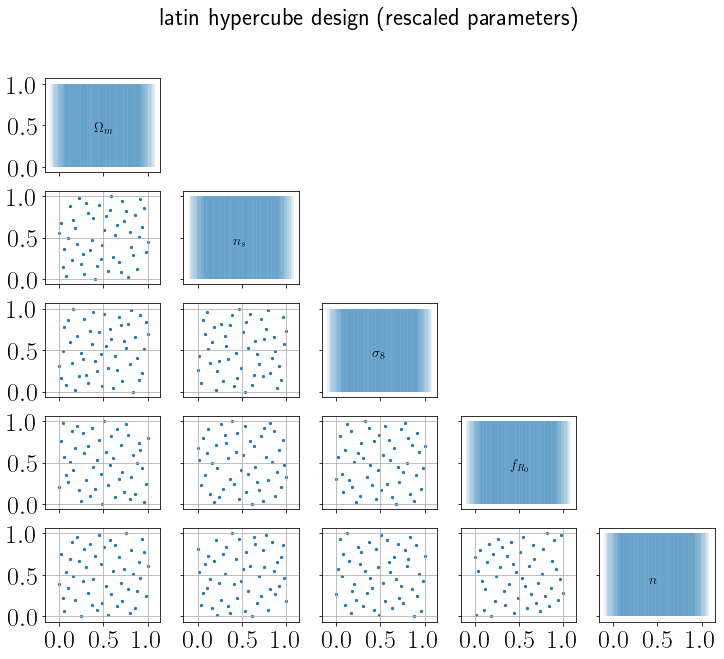

In [46]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

def rescale01(f):
    return (f - np.min(f)) / (np.max(f) - np.min(f))

lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(12, 10) )
    plt.suptitle('latin hypercube design (rescaled parameters)', fontsize = 24)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
                
#             if (j > i):
                
                
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)

    for i in range(lhd.shape[1]):
        for j in range(i + 1, lhd.shape[1]):

            plt.delaxes(a[i][j])
    plt.show()


plot_params(lhd)

In [47]:
########################### PCA ###################################
def PCA_decomp():
#     Dicekriging = importr('DiceKriging')
    r('require(foreach)')
    ro.r.assign("nrankmax", nRankMax)
    r('svd(y_train2)')
    r('svd_decomp2 <- svd(y_train2)')
    r('svd_weights2 <- svd_decomp2$u[, 1:nrankmax] %*% diag(svd_decomp2$d[1:nrankmax])')


In [48]:
######################## GP PREDICTION ###############################

def GP_model_load(GPmodel):
    GPareto = importr('GPareto')

    ro.r('''

    GPmodel <- gsub("to", "",''' + GPmodel + ''')

    ''')

    r('''if(file.exists(GPmodel)){
            load(GPmodel)
        }else{
            print("ERROR: No trained GP file")
         }''')
#     print('Loaded: ', GPmodel)
    
    
def GP_predict(para_array):
    GPareto = importr('GPareto')


    para_array = np.expand_dims(para_array, axis=0)
    nr, nc = para_array.shape
    Br = ro.r.matrix(para_array, nrow=nr, ncol=nc)

    ro.r.assign("Br", Br)
#     r('print("loaded model in R kernel: ")')
#     r('print(GPmodel)')

    r('wtestsvd2 <- predict_kms(models_svd2, newdata = Br , type = "UK")')
    r('reconst_s2 <- t(wtestsvd2$mean) %*% t(svd_decomp2$v[,1:nrankmax])')

    y_recon = np.array(r('reconst_s2'))

    return y_recon[0]

In [49]:
#################### PCA DECOMPOSITION DONE AGAIN ##############
# Dicekriging = importr('DiceKriging')

PCA_decomp()

#################### LOADING TRAINED GP MODEL ##############

GP_model_load(GPmodel)

R[write to console]: Loading required package: foreach



In [50]:
print(GPmodel)

"GP_model_213Smooth_rank2snap97.RData"


Time per emulation 0.049  s
Time per emulation 0.048  s
Time per emulation 0.050  s


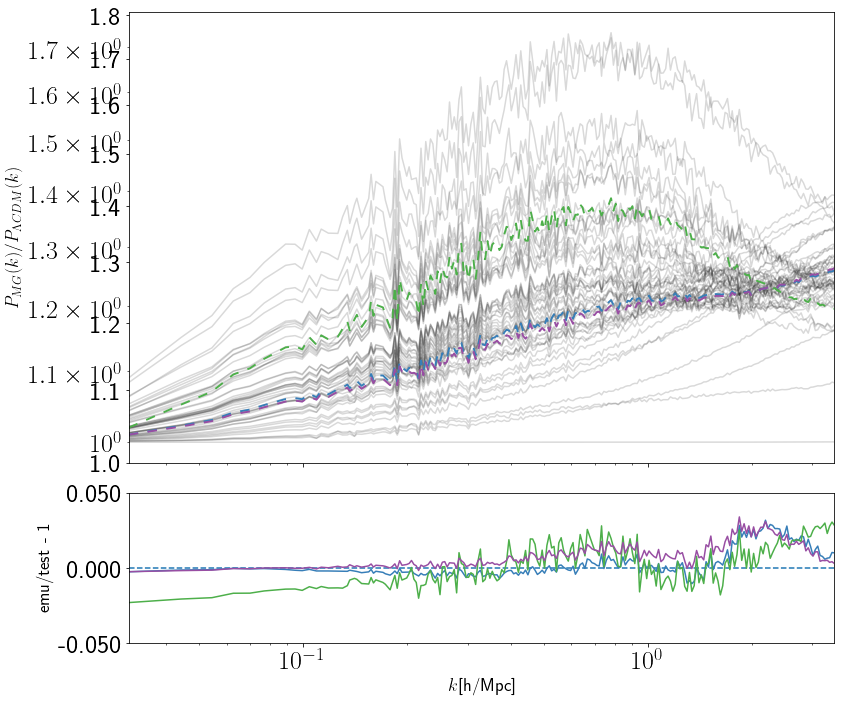

In [51]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
    ax1.set_ylim(-5e-2, 5e-2)

    ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


    color_id = 0
    for x_id in del_idx[1:]:
        color_id = color_id + 1

        time0 = time.time()
        x_decodedGPy = GP_predict(parameter_array_all[x_id])  ## input parameters
        time1 = time.time()
        print('Time per emulation %0.3f' % (time1 - time0), ' s')
        x_test = PmPl_all[x_id]

        ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
#         ax0.plot(kvals, x_test, alpha=0.7, label='test', color=plt.cm.Set1(color_id))

        ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))


plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

In [9]:
x_decodedGPy.shape

(213,)

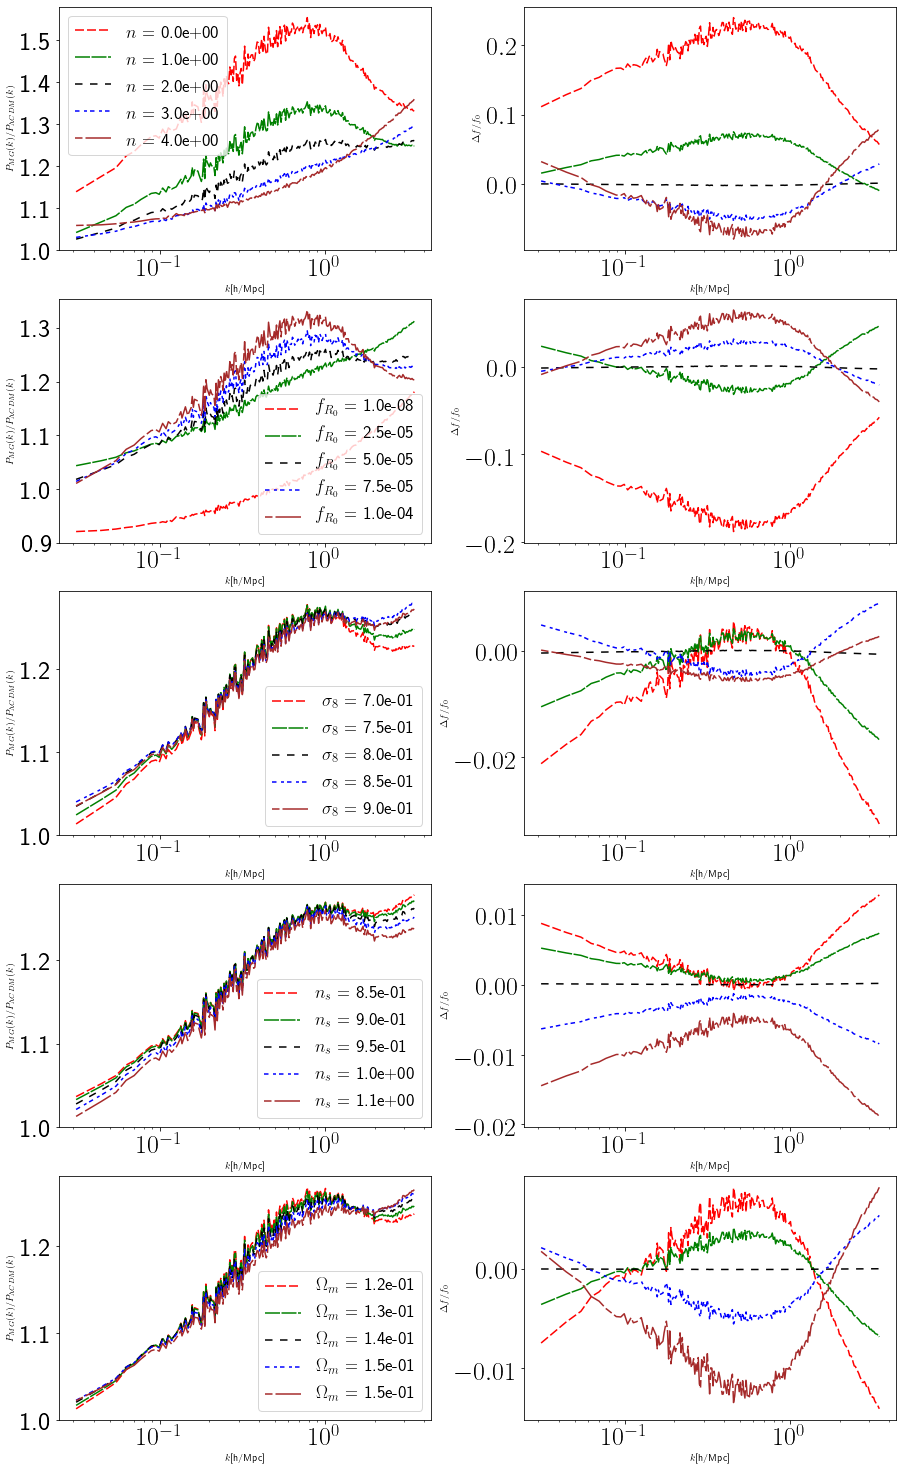

In [10]:
PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = np.max(parameter_array, axis = 0)
    allMin = np.min(parameter_array, axis = 0)
    allMean = np.mean(parameter_array, axis = 0)
    Pk_mean = GP_predict(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            x_decodedGPy = GP_predict(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()

In [11]:
######### CALLING THE EMULATOR ##############
#### input arguments: (Om, ns, s8, fR0, n)
#### output: P_mg/P_lcdm in 20 bins
#### Example: 

GP_predict([0.1, 1.0, 0.8, 3e-5, 1.5])

array([1.00831965, 1.02830138, 1.04049175, 1.0565258 , 1.06273958,
       1.07218281, 1.08412004, 1.08569723, 1.08272447, 1.09473188,
       1.08727188, 1.09817277, 1.09307447, 1.099128  , 1.10551756,
       1.1126223 , 1.10390971, 1.11388493, 1.1199648 , 1.10800001,
       1.11915274, 1.13495904, 1.12010538, 1.1313219 , 1.12938478,
       1.12251931, 1.11040531, 1.11963194, 1.15272507, 1.11488517,
       1.15999883, 1.14749541, 1.13812995, 1.14587655, 1.14078398,
       1.13988021, 1.1380128 , 1.12135401, 1.15750238, 1.1330337 ,
       1.16257989, 1.14962055, 1.16643461, 1.1602865 , 1.14705738,
       1.17179102, 1.15812746, 1.17560412, 1.16435343, 1.16519675,
       1.18882098, 1.17600575, 1.18448709, 1.17054646, 1.19941532,
       1.20150511, 1.17144912, 1.17862823, 1.16205629, 1.18166962,
       1.18792416, 1.16603172, 1.18871245, 1.21744514, 1.18923673,
       1.18847212, 1.20702462, 1.19289039, 1.20513248, 1.20762039,
       1.20913401, 1.20079881, 1.20285778, 1.21701436, 1.22538

In [12]:

#################################################################################################
#################################################################################################
############################################## MCMC #############################################
#################################################################################################

import emcee
import pygtc

#### parameters that define the MCMC

ndim = 5
nwalkers = 100  # 200 #600  # 500
nrun_burn = 10  # 50 # 50  # 300
nrun = 300  # 300  # 700


In [41]:
#### FAKE DATA GENERATION #####


create_fake_fiducial = True

if create_fake_fiducial:
    dirDataIn = "./Data/FiducialData/"

    seed = 1
    np.random.seed(seed)

    Pk_ratio = np.loadtxt(dirDataIn + 'ratios213.txt')[:, 25].T
    Pk_ratio = (1 + np.random.rand()/100)*Pk_ratio
    np.savetxt(dirDataIn + 'fiducial_ratio213.txt', Pk_ratio)

    cov_mat = np.zeros(shape = (Pk_ratio.shape[0], Pk_ratio.shape[0]))

    for i in range(Pk_ratio.shape[0]):
        cov_mat[i, i] = (1 + kvals[i]**2)*(1 + np.random.rand())*np.sqrt(Pk_ratio[i])/5000

    np.savetxt(dirDataIn + 'fiducial_cov213.txt', cov_mat)

In [42]:
cov_mat.shape

(213, 213)

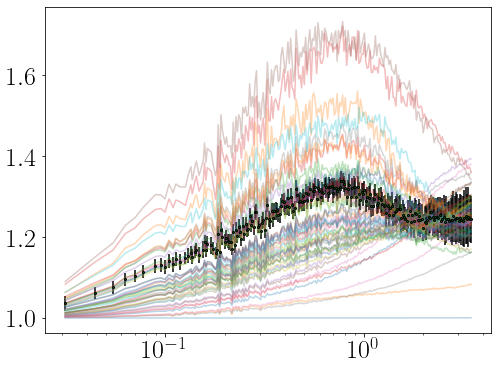

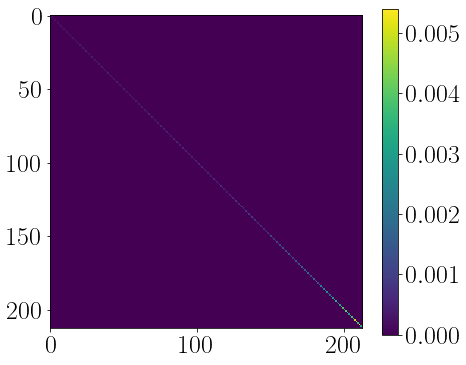

In [43]:
########## REAL DATA with ERRORS #############################

dirDataIn = "./Data/FiducialData/"
Pk_ratio = np.loadtxt(dirDataIn + 'fiducial_ratio213.txt')
cov_mat = np.loadtxt(dirDataIn + 'fiducial_cov213.txt')



kvals_max = 3.2
kvals_cond = np.where(Pk_ratio < kvals_max)
# kvals_cond = True

x = np.array(kvals)
y = Pk_ratio
yerr_diag = np.sqrt(np.diag(cov_mat))



x = x[kvals_cond]
y = y[kvals_cond]

yerr_diag = yerr_diag[kvals_cond]
# emax = emax[ls_cond][:,ls_cond][:,0,:]
# cov_mat =  cov_mat[:len(kvals_cond[0]), :len(kvals_cond[0])]
## Only works if slicing is done at a corner.
# i.e., if ls_cond corresponds to continuous array entries in l
icov = np.linalg.inv(cov_mat)


plt.figure(34, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None')
plt.plot(kvals, np.loadtxt(dirDataIn + 'ratios213.txt')[:, 1:], alpha = 0.3)
plt.xscale('log')
# plt.show()

plt.savefig('Plots/PowerSpect_emu.pdf')


plt.figure(43, figsize = (7, 6))
plt.imshow(cov_mat)
plt.colorbar()
# plt.show()

plt.savefig('Plots/Cov_mat.pdf')


In [16]:
y.shape

(213,)

In [17]:
kvals.shape

(213,)

In [18]:

# #### Cosmological Parameters ########################################

# parameter_array_all.min(axis=0)

# para1 = [allLabels[0], 0.1188, 0.12, 0.155]  # Actual 0.119
# para2 = [allLabels[1], 0.02230, 0.0215, 0.0235]
# para3 = [allLabels[2], 0.8159, 0.7, 0.89]
# para4 = [allLabels[3], 0.6774, 0.55, 0.85]
# para5 = [allLabels[4], 0.9667, 0.85, 1.05]


In [19]:

#### Cosmological Parameters ########################################

allMin = parameter_array_all.min(axis=0)
allMax = parameter_array_all.max(axis=0)
# allMean = parameter_array_all.mean(axis=0)
allMean = parameter_array_all[25]


para1 = [allLabels[0], allMean[0], allMin[0], allMax[0]]  # Actual 0.119
para2 = [allLabels[1], allMean[1], allMin[1], allMax[1]]
para3 = [allLabels[2], allMean[2], allMin[2], allMax[2]]
para4 = [allLabels[3], allMean[3], allMin[3], allMax[3]]
para5 = [allLabels[4], allMean[4], allMin[4], allMax[4]]


In [20]:
#################### CHAIN INITIALIZATION ##########################

## 2 options

Uniform_init = True
if Uniform_init:
    # Choice 1: chain uniformly distributed in the range of the parameters
    pos_min = np.array( [para1[2], para2[2], para3[2], para4[2], para5[2]] )
    pos_max = np.array( [para1[3], para2[3], para3[3], para4[3], para5[3]] )
    psize = pos_max - pos_min
    pos0 = [pos_min + psize * np.random.rand(ndim) for i in range(nwalkers)]

True_init = False
if True_init:
    # Choice 2: chain is initialized in a tight ball around the expected values
    pos1 = [[para1[1] * 1.2, para2[1] * 0.8, para3[1] * 0.9, para4[1] * 1.1, para5[1] * 1.2] +
            1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

MaxLikelihood_init = False
if MaxLikelihood_init:
    # Choice 2b: Find expected values from max likelihood and use that for chain initialization
    # Requires likehood function below to run first

    import scipy.optimize as op

    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [para1[1], para2[1], para3[1], para4[1], para5[1]], args=(x, y, yerr))
    p1_ml, p2_ml, p3_ml, p4_ml, p5_ml = result["x"]
    print(result['x'])

    pos0 = [result['x'] + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]


In [21]:
pos_max

array([1.55e-01, 1.05e+00, 9.00e-01, 1.00e-04, 4.00e+00])

In [22]:
# pygtc.plotGTC(pos)

In [23]:
# Visualize the initialization

PriorPlot = False

if PriorPlot:
    fig = pygtc.plotGTC(pos0, labels=[para1[0], para2[0], para3[0], para4[0], para5[0]],
                        range=[[para1[2], para1[3]], [para2[2], para2[3]],
                               [para3[2], para3[3]],
                               [para4[2], para4[3]], [para5[2], para5[3]]],
                        truths=[para1[1], para2[1], para3[1], para4[1], para5[1]])
    fig.set_size_inches(10, 10)

######### not working #######################

In [24]:
allMin

array([1.2e-01, 8.5e-01, 7.0e-01, 1.0e-08, 0.0e+00])

In [25]:
allMax

array([1.55e-01, 1.05e+00, 9.00e-01, 1.00e-04, 4.00e+00])

In [26]:
p1, p2, p3, p4, p5 = allMean

In [27]:
if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        print('Success')
print('fail')

Success
fail


In [28]:
def lnprior(theta):
    p1, p2, p3, p4, p5 = theta
    # if 0.12 < p1 < 0.155 and 0.7 < p2 < 0.9:
    if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return 0.0
    return -np.inf


In [29]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

-inf

In [30]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4, p5 = theta

    new_params = np.array([p1, p2, p3, p4, p5])

    model = GP_predict(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
#     return -0.5 * (np.sum(((y - model) / yerr) ** 2.))

In [31]:



def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    # return lp + lnlike_diag(theta, x, y, yerr)
    return lp + lnlike(theta, x, y, yerr)


############################# PARAMETERS ##############################

In [32]:

######### MCMC #######################


## Sample implementation :
# http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html
# https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html


# Let us setup the emcee Ensemble Sampler
# It is very simple: just one, self-explanatory line

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr_diag))
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, icov))

###### BURIN-IN #################

time0 = time.time()
# burnin phase
pos, prob, state = sampler.run_mcmc(pos0, nrun_burn)
sampler.reset()
time1 = time.time()
print('burn-in time:', time1 - time0)

burn-in time: 45.7377142906189


In [33]:


###### MCMC ##################
time0 = time.time()
# perform MCMC
pos, prob, state = sampler.run_mcmc(pos, nrun)
time1 = time.time()
print('mcmc time:', time1 - time0)

samples = sampler.flatchain
samples.shape

###########################################################################

mcmc time: 1039.6705808639526


(30000, 5)

In [34]:

###########################################################################
samples_plot = sampler.chain[:, :, :].reshape((-1, ndim))

np.savetxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
    nrun) + '.txt', sampler.chain[:, :, :].reshape((-1, ndim)))

####### FINAL PARAMETER ESTIMATES #######################################



In [35]:

samples_plot = np.loadtxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(
    nwalkers) + '_run' + str(nrun) + '.txt')

# samples = np.exp(samples)
p1_mcmc, p2_mcmc, p3_mcmc, p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1],
                                                                               v[1] - v[0]) , zip(*np.percentile(samples_plot, [16, 50, 84], axis=0)))
print('mcmc results:', p1_mcmc[0], p2_mcmc[0], p3_mcmc[0], p4_mcmc[0], p5_mcmc[0])


mcmc results: 0.13683640142372563 0.940556511478852 0.8221203177156838 5.713969671829681e-05 1.1689163570139829


In [36]:
# plt.contourf(samples_plot[:,:2])

/anaconda3/envs/env_rpy/lib/python3.7/site-packages/pygtc/pygtc.py:1053: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  normed=True, bins=nBins)


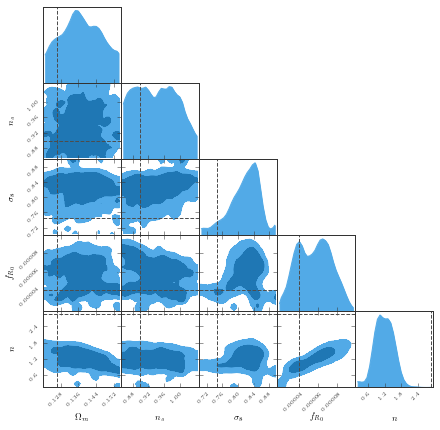

In [37]:
####### CORNER PLOT ESTIMATES #######################################

CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(samples_plot,
                        paramNames=[para1[0], para2[0], para3[0], para4[0], para5[0]],
                        truths=[para1[1], para2[1], para3[1], para4[1], para5[1]],
                        figureSize='MNRAS_page')  # , plotDensity = True, filledPlots = False,\smoothingKernel = 0, nContourLevels=3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

In [68]:
lnlike([0.1, 1.1, 0.8, 3e-5, 1.5], x, y, yerr_diag)

-12442.515864022633

In [39]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

-inf

In [40]:
pos0[0]

array([1.24727771e-01, 9.51132433e-01, 7.04304961e-01, 9.47975414e-05,
       3.30846188e+00])

In [41]:
[para1[2], para2[2], para3[2], para4[2], para5[2]]


[0.12, 0.85, 0.7, 1e-08, 0.0]